In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

Use tf.keras.datasets.cifar10.load_data() to get the data
split to 70 - 30 train / val using train_test_split

In [3]:
ds=tf.keras.datasets.cifar10.load_data() 

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
x_train_ds=ds[0][0][:40000]
y_train_ds=ds[0][1][:40000]
x_val_ds=ds[0][0][40000:]
y_val_ds=ds[0][1][40000:]
x_test_ds=ds[1][0]
y_test_ds=ds[1][1]
num_classes=len(np.unique(y_test_ds))
num_classes


10

In [5]:
len(x_train_ds)

40000

In [6]:


NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [8]:
print("Train samples:", x_train_ds.shape, y_train_ds.shape)
print("Test samples:", x_test_ds.shape, y_test_ds.shape)

Train samples: (40000, 32, 32, 3) (40000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


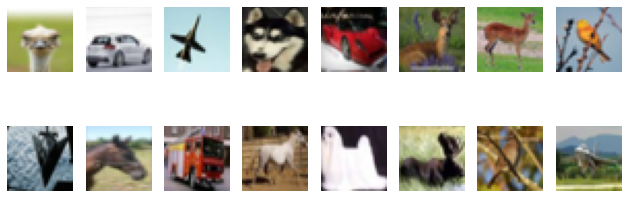

In [9]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 5, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train_ds))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train_ds[random_index, :])
       # ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

Prepare data

* normalize the input like $x_{\text{norm}} = \frac{x}{255} - 0.5$
* We need to convert class labels to one-hot encoded vectors. Use `keras.utils.to_categorical`.

In [10]:
x_train = tf.keras.layers.experimental.preprocessing.Rescaling(scale=(1./255))(x_train_ds) #for scaling
x_test = tf.keras.layers.experimental.preprocessing.Rescaling(scale=(1./255))(x_test_ds)
x_val = tf.keras.layers.experimental.preprocessing.Rescaling(scale=(1./255))(x_val_ds)

In [12]:
y_train=keras.utils.to_categorical(y_train_ds,num_classes=num_classes)
y_test=keras.utils.to_categorical(y_test_ds,num_classes=num_classes)
y_val=keras.utils.to_categorical(y_val_ds,num_classes=num_classes)

# Define CNN architecture

In [13]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

In [14]:
def first_model():

    model = Sequential()
    model.add(Conv2D(10, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [16]:
model1 = first_model()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 10)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 10, 10, 100)       1100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 100)       0         
_________________________________________________________________
dense_3 (Dense)              (None, 10, 10, 10)        1010      
Total params: 2,390
Trainable params: 2,390
Non-trainable params: 0
_________________________________________________________________


In [18]:
model1.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])


In [19]:
model1.fit(x_train,y_train,
           epochs=10,
           validation_data=(x_val,y_val))

Epoch 1/10


ValueError: ignored

### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```


Train it with Adam optimizer with default params.


### Second step (after you've trained it)

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer


In [38]:
def second_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(10, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [39]:
K.clear_session() 
model2=second_model()
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 10)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 10)        0         
_________________________________________________________________
dense (Dense)                (None, 10, 10, 100)       1100      
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 100)       0         
_________________________________________________________________
dense_1 (Dense)              (None, 10, 10, 10)        1010      
Total params: 2,430
Trainable params: 2,410
Non-trainable params: 20
_____________________________________________________

In [40]:
model2.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=tf.keras.optimizers.Adamax(),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

In [41]:
model2.fit(
    x_train, y_train,  # prepared data
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    shuffle=True,
)

Epoch 1/10


ValueError: ignored

In [54]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [55]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          1

# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [56]:
BATCH_SIZE = 32
EPOCHS = 10

#K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)

  # report accuracy during training
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=tf.keras.optimizers.Adamax(),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)


# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

Epoch 1/10
1250/1250 [==============================] - 208s 166ms/step - loss: 1.6426 - accuracy: 0.4051 - val_loss: 1.3830 - val_accuracy: 0.5098
Epoch 2/10
1250/1250 [==============================] - 207s 165ms/step - loss: 1.0574 - accuracy: 0.6277 - val_loss: 0.9365 - val_accuracy: 0.6692
Epoch 3/10
1250/1250 [==============================] - 205s 164ms/step - loss: 0.8518 - accuracy: 0.7000 - val_loss: 0.8943 - val_accuracy: 0.6848
Epoch 4/10
1250/1250 [==============================] - 207s 166ms/step - loss: 0.7108 - accuracy: 0.7495 - val_loss: 0.9942 - val_accuracy: 0.6813
Epoch 5/10
1250/1250 [==============================] - 207s 166ms/step - loss: 0.5970 - accuracy: 0.7915 - val_loss: 0.8765 - val_accuracy: 0.7004
Epoch 6/10
1250/1250 [==============================] - 209s 167ms/step - loss: 0.4905 - accuracy: 0.8272 - val_loss: 0.8928 - val_accuracy: 0.7062
Epoch 7/10
1250/1250 [==============================] - 209s 168ms/step - loss: 0.3920 - accuracy: 0.8614 - val_

In [57]:


# save weights to file
model.save_weights("weights.h5")

In [58]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

## Evaluate model

In [59]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_pred_test_classes


array([3, 8, 8, ..., 5, 4, 7])

In [60]:
rounded_labels=np.argmax(y_test, axis=1)

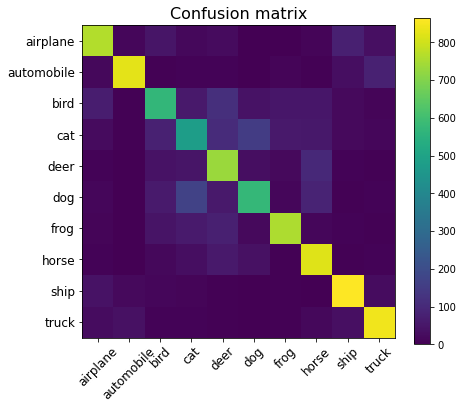

Test accuracy: 0.7244


In [62]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(rounded_labels, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_ds, y_pred_test_classes))

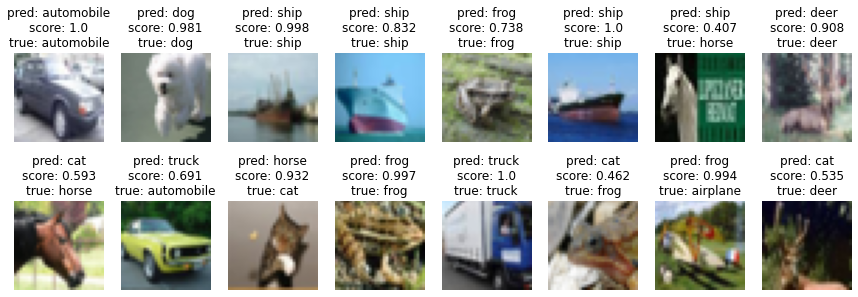

In [64]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[rounded_labels[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()